PHÂN TÍCH ỨNG DỤNG MÔ HÌNH LOGISTIC REGRESSION VÀ STACKING CHO BÀI TOÁN DỰ ĐOÁN BỆNH ĐỘT QUỴ

IMPORT THƯ VIỆN

In [1]:
import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd

# #visulaization modules
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

#Common model helpers
from sklearn.preprocessing import (StandardScaler, LabelEncoder, OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, auc, precision_score, 
                             recall_score, f1_score, roc_auc_score, 
                             confusion_matrix, classification_report, roc_curve,
                             cohen_kappa_score, mean_absolute_error, mean_squared_error)

# model algorithams
from sklearn.ensemble import (StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

ĐỌC DỮ LIỆU TỪ DATAFRAME

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print(df.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


In [3]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


DATA PROCESSING (Tiền xử lý dữ liệu)

1. Null handling (Đếm số lượng dữ liệu Null)

In [4]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

2. Null handling for bmi column (Xử lý dữ liệu Null trong bmi)

In [5]:
mean_bmi = df['bmi'].mean()

# Thay thế giá trị null trong cột 'bmi' bằng giá trị trung bình
df['bmi'].fillna(mean_bmi, inplace=True)

# Kiểm tra lại số lượng giá trị null
print(df.isnull().sum())


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


3. 'Unknown' handling in smoking_status column (Xử lý dữ liệu "Unknown" trong cột smoking_status)

In [6]:
count_unknown = df['smoking_status'].value_counts().get('Unknown', 0)
print("Numbers of 'Unknown' data before handling:", count_unknown)

Numbers of 'Unknown' data before handling: 1544


In [7]:
df['smoking_status'].replace('Unknown', np.nan, inplace=True)
column_values = df['smoking_status'].dropna() 
sampled_values = np.random.choice(column_values, size=df['smoking_status'].isnull().sum(), replace=True)
df.loc[df['smoking_status'].isnull(), 'smoking_status'] = sampled_values

count_unknown = df['smoking_status'].value_counts().get('Unknown', 0)
print("Numbers of 'Unknown' data after handling:", count_unknown)

Numbers of 'Unknown' data after handling: 0


4. Outliers handling (Xử lý nhiễu)

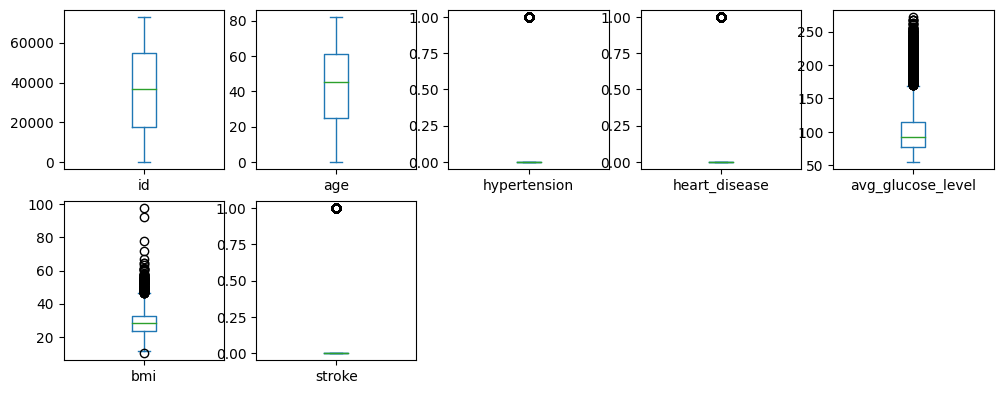

In [8]:
ax_array = df.plot(kind="box", subplots=True, figsize=(12, 12), layout=(5, 5)) # Show the map of outliers data in the dataframe => bmi is the problem
import matplotlib.pyplot as plt
plt.show()

Từ biểu đồ trên, ta có thể thấy rằng cột bmi chứa nhiều giá trị nhiễu => giảm hiệu suất của mô hình

Loại bỏ những giá trị >= 55 trong cột bmi

In [9]:
df=df[(df['bmi'] < 60)]
df=df[(df['bmi'] <= 55)]

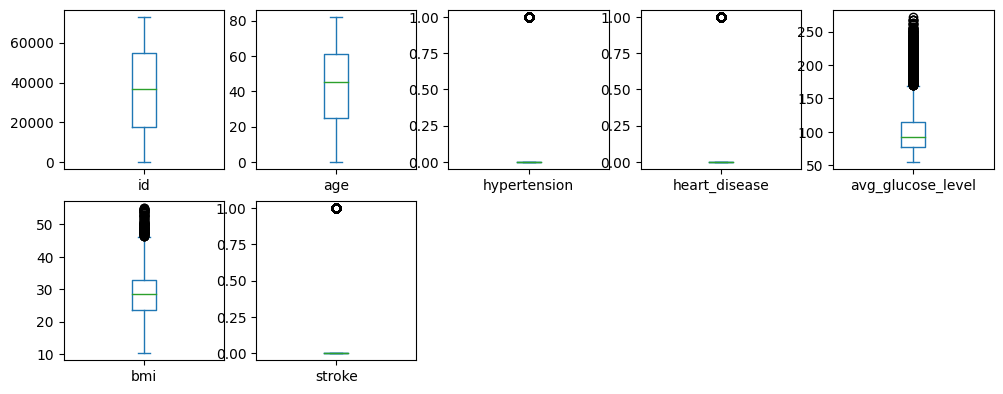

In [10]:
x_array = df.plot(kind="box", subplots=True, figsize=(12, 12), layout=(5, 5)) # Show the map of outliers data in the dataframe after handling
import matplotlib.pyplot as plt
plt.show()

5. "Other" Handling in gender Column and Eliminate id column (Xử lý giá trị 'other' trong gender và loại bỏ cột id)

In [11]:
df.drop(['id'],axis=1,inplace = True)

In [12]:
count_other = (df['gender'] == 'Other').sum()
print("Numbers of 'Other' in gender column:", count_other)

Numbers of 'Other' in gender column: 1


In [13]:
df=df[(df['gender'] != 'Other')]
count_other = (df['gender'] == 'Other').sum()
print("Numbers of 'Other' in gender column:", count_other)

Numbers of 'Other' in gender column: 0


6. Category Data Encoding (Biến đổi thành các giá trị nhị phân phù hợp cho việc xây dựng mô hình)

Use Label Encoding for gender, ever_married, Residence_type

In [14]:
df["gender"]=df["gender"].str.replace("Male","1")
df["gender"]=df["gender"].str.replace("Female","0")
df["gender"]=df["gender"].astype("int32")

df["ever_married"]=df["ever_married"].str.replace("Yes","1")
df["ever_married"]=df["ever_married"].str.replace("No","0")
df["ever_married"]=df["ever_married"].astype("int32")

df["Residence_type"]=df["Residence_type"].str.replace("Rural","0")
df["Residence_type"]=df["Residence_type"].str.replace("Urban","1")
df["Residence_type"]=df["Residence_type"].astype("int32")

In [15]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,228.69,36.600000,formerly smoked,1
1,0,61.0,0,0,1,Self-employed,0,202.21,28.893237,never smoked,1
2,1,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1
3,0,49.0,0,0,1,Private,1,171.23,34.400000,smokes,1
4,0,79.0,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,Private,1,83.75,28.893237,never smoked,0
5106,0,81.0,0,0,1,Self-employed,1,125.20,40.000000,never smoked,0
5107,0,35.0,0,0,1,Self-employed,0,82.99,30.600000,never smoked,0
5108,1,51.0,0,0,1,Private,0,166.29,25.600000,formerly smoked,0


7. Balancing the data (Cân bằng dữ liệu trong DataFrame)

In [16]:
data_0 = df[df.iloc[:,-1]==0]
data_1 = df[df.iloc[:,-1]==1]

df['stroke'].value_counts()

stroke
0    4828
1     248
Name: count, dtype: int64

In [17]:
from sklearn.utils import resample

data_1 = resample(data_1,replace=True , n_samples=data_0.shape[0] , random_state=123 )

In [18]:
df = np.concatenate((data_0,data_1))

#create the balanced dataframe
df = pd.DataFrame(df)
df.columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status', 'stroke']

In [19]:
data_0 = df[df.iloc[:,-1]==0]
data_1 = df[df.iloc[:,-1]==1]

df['stroke'].value_counts()

stroke
0    4828
1    4828
Name: count, dtype: int64

In [20]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,3.0,0,0,0,children,0,95.12,18.0,never smoked,0
1,1,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0
2,0,8.0,0,0,0,Private,1,110.89,17.6,never smoked,0
3,0,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0
4,1,14.0,0,0,0,Never_worked,0,161.28,19.1,formerly smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
9651,1,81.0,0,0,1,Self-employed,0,91.54,31.4,never smoked,1
9652,0,72.0,0,0,1,Private,0,97.92,26.9,smokes,1
9653,0,79.0,0,1,0,Private,1,205.33,31.0,smokes,1
9654,0,66.0,0,0,1,Self-employed,1,101.45,28.893237,smokes,1


8. One-hot encoding for work_type and smoking_status

In [21]:
df_resampled = pd.get_dummies(df , columns =  ['gender','ever_married','work_type','Residence_type','smoking_status'])


In [22]:
df_resampled # DataFrame sau khi được tiền xử lý

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_0,gender_1,ever_married_0,ever_married_1,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_0,Residence_type_1,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3.0,0,0,95.12,18.0,0,False,True,True,False,False,False,False,False,True,True,False,False,True,False
1,58.0,1,0,87.96,39.2,0,False,True,False,True,False,False,True,False,False,False,True,False,True,False
2,8.0,0,0,110.89,17.6,0,True,False,True,False,False,False,True,False,False,False,True,False,True,False
3,70.0,0,0,69.04,35.9,0,True,False,False,True,False,False,True,False,False,True,False,True,False,False
4,14.0,0,0,161.28,19.1,0,False,True,True,False,False,True,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9651,81.0,0,0,91.54,31.4,1,False,True,False,True,False,False,False,True,False,True,False,False,True,False
9652,72.0,0,0,97.92,26.9,1,True,False,False,True,False,False,True,False,False,True,False,False,False,True
9653,79.0,0,1,205.33,31.0,1,True,False,True,False,False,False,True,False,False,False,True,False,False,True
9654,66.0,0,0,101.45,28.893237,1,True,False,False,True,False,False,False,True,False,False,True,False,False,True


CHIA DỮ LIỆU TRAINING VÀ TEST (80% TRAINING, 20% TEST)

In [23]:
x1 = df_resampled.drop('stroke', axis = 1)
y1 = pd.to_numeric( df_resampled['stroke'])

scaler = StandardScaler()
x_resampled = scaler.fit_transform(x1)

x_train_resampled , x_test_resampled , y_train_resampled , y_test_resampled = train_test_split(x_resampled,y1,test_size = .20)

XÂY DỰNG MÔ HÌNH LOGISTIC REGRESSION

In [24]:
# Khởi tạo mô hình Logistic Regression
logistic_model = LogisticRegression()

# Huấn luyện mô hình trên tập huấn luyện
logistic_model.fit(x_train_resampled, y_train_resampled)

# Dự đoán kết quả trên tập kiểm tra
y_pred_lg = logistic_model.predict(x_test_resampled)

# Các thông số đánh giá mô hình
accuracy = accuracy_score(y_test_resampled, y_pred_lg)
print("Accuracy of Logistic Regression:", accuracy)
print("\nClassification Report of the Logistics Regression:\n", classification_report(y_test_resampled, y_pred_lg))
print("Confusion Matrix of the Logistic Regression:\n", confusion_matrix(y_test_resampled, y_pred_lg))

Accuracy of Logistic Regression: 0.7738095238095238

Classification Report of the Logistics Regression:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75       922
           1       0.77      0.82      0.79      1010

    accuracy                           0.77      1932
   macro avg       0.77      0.77      0.77      1932
weighted avg       0.77      0.77      0.77      1932

Confusion Matrix of the Logistic Regression:
 [[671 251]
 [186 824]]


XÂY DỰNG MÔ HÌNH DECISION TREE (BASE MODEL ĐỂ SO SÁNH VỚI MÔ HÌNH STACKING)

In [25]:
clf_tree = DecisionTreeClassifier(random_state=42)

# Huấn luyện mô hình trên tập huấn luyện
clf_tree.fit(x_train_resampled, y_train_resampled)

# Dự đoán trên tập kiểm tra
y_pred_tree = clf_tree.predict(x_test_resampled)

# Đánh giá mô hình phân lớp
accuracy_tree = accuracy_score(y_test_resampled, y_pred_tree)
print("Accuracy of Decision Tree:", accuracy_tree)
print("\nClassification Report of the Decision Tree:\n", classification_report(y_test_resampled, y_pred_tree))
print("Confusion Matrix of the Decision Tree:\n", confusion_matrix(y_test_resampled, y_pred_tree))


Accuracy of Decision Tree: 0.9663561076604554

Classification Report of the Decision Tree:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       922
           1       0.94      1.00      0.97      1010

    accuracy                           0.97      1932
   macro avg       0.97      0.96      0.97      1932
weighted avg       0.97      0.97      0.97      1932

Confusion Matrix of the Decision Tree:
 [[ 857   65]
 [   0 1010]]


XÂY DỰNG MÔ HÌNH STACKING (BASE MODEL: LOGISTIC REGRESSION, DECISION TREE)

In [26]:
base_models = [
    ('Logistic', LogisticRegression(random_state=42)),
    ('Decision_Tree', DecisionTreeClassifier(random_state=42))
]

# Tạo mô hình stacking
stacking_model = StackingClassifier(estimators=base_models, final_estimator=DecisionTreeClassifier())

# Huấn luyện mô hình stacking trên tập huấn luyện
stacking_model.fit(x_train_resampled, y_train_resampled)

# Dự đoán trên tập kiểm tra
y_pred_stacking = stacking_model.predict(x_test_resampled)

# Tính độ chuẩn xác của mô hình stacking
accuracy_stacking = accuracy_score(y_test_resampled, y_pred_stacking)
print("Accuracy of Stacking Classifier:", accuracy_stacking)
print("\nClassification Report of the Stacking Model:\n", classification_report(y_test_resampled, y_pred_stacking))
print("Confusion Matrix of the Stacking Model:\n", confusion_matrix(y_test_resampled, y_pred_stacking))

Accuracy of Stacking Classifier: 0.9032091097308489

Classification Report of the Stacking Model:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       922
           1       0.94      0.87      0.90      1010

    accuracy                           0.90      1932
   macro avg       0.90      0.90      0.90      1932
weighted avg       0.91      0.90      0.90      1932

Confusion Matrix of the Stacking Model:
 [[866  56]
 [131 879]]
